In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Tasks

* Cap sizes and update zero padding
* Embeddding layer first 
* Specify size of image as input to embedding (later)


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import gc

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-beta1


## Get training and validation set

In [3]:
from src.utils import read_shapefile
from sklearn.model_selection import train_test_split
from config import raw_data_dir

train_shp_df = read_shapefile('train')
test_shp_df = read_shapefile('test')

# Labels must be zero indexed
train_shp_df['Crop_Id_Ne'] = train_shp_df['Crop_Id_Ne'].astype(int) - 1

print(train_shp_df.shape)
train_shp_df.head()

(2494, 4)


,Area,Subregion,Crop_Id_Ne,geometry
Field_Id,,,,
1,0.915905,3,7,"POLYGON ((613924.3324000851 6793991.295069702,..."
2,2.064410,3,5,"POLYGON ((614404.0717397591 6794020.579634549,..."
3,1.080300,3,7,"POLYGON ((614320.2146632321 6793964.242091182,..."
4,1.316190,3,7,"POLYGON ((614560.5326844405 6794002.249461887,..."
7,5.529220,3,7,"POLYGON ((614596.6564746551 6794269.865436315,..."


In [4]:
class_names = pd.read_csv(os.path.join(raw_data_dir, 'crop_id_list.csv'))
class_names.crop_id = class_names.crop_id.astype(int) - 1
class_names = class_names.set_index('crop_id')

class_names

,crop
crop_id,
0,Cotton
1,Dates
2,Grass
3,Lucern
4,Maize
5,Pecan
6,Vacant
7,Vineyard
8,"Vineyard & Pecan (""Intercrop"")"


### Setup training and validation data

In [5]:
train_ids_list = train_shp_df.index.to_list()
train_labels = np.array(train_shp_df['Crop_Id_Ne'])

test_ids_list = test_shp_df.index.to_list()

## Read satellite data for one dump, and one spectral band

In [6]:
import os
from glob import glob
from config import interim_data_dir

date = '2017-01-01'
band = 'B05'

# Get list of images filepaths
train_images = glob(os.path.join(interim_data_dir, 'masks', 'train', date, f'*_{band}.npy'))
test_images = glob(os.path.join(interim_data_dir, 'masks', 'test', date, f'*_{band}.npy'))

# Load images
train_imgs = [np.load(f) for f in train_images]
test_imgs = [np.load(f) for f in test_images]

len(train_imgs),len(test_imgs)

(2494, 1074)

## Analyse Max of widths and heights

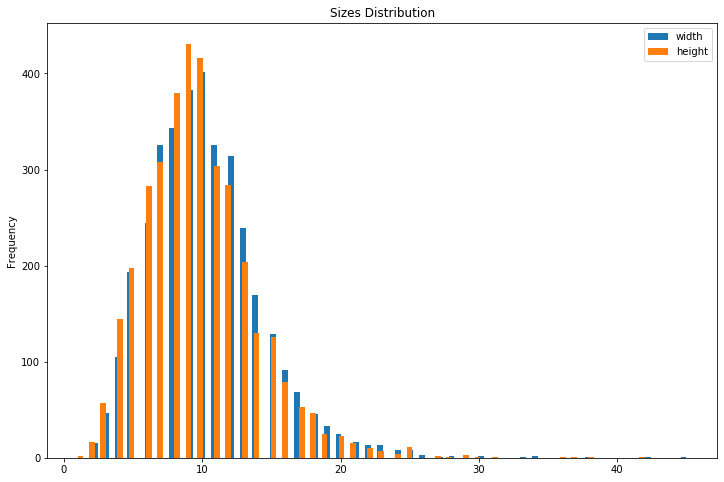

In [7]:
import pandas as pd
from operator import itemgetter

all_images = train_imgs + test_imgs
all_ids = train_ids_list + test_ids_list

shapes = {id: x.shape for  id,x in zip(all_ids, all_images)}

widths = [x[0] for x in shapes.values()]
heights = [x[1] for x in shapes.values()]

w_plot = pd.Series(widths).plot.hist(bins=100, title='Sizes Distribution', label='width', figsize=(12,8))
h_plot = pd.Series(heights).plot.hist(bins=100, title='Sizes Distribution', label='height', figsize=(12,8))
plt.legend()
display(w_plot)
display(h_plot)

**Insight**

Seems like very few images below 30 x 30

In [8]:
MAX_DIMS = (28, 28)

# Get number of farms with dims more than max
N_large = len([x for x in all_images if (x.shape[0] > MAX_DIMS[0]  or x.shape[1] > MAX_DIMS[1])])
print('{} farms have width or height > max value'.format(N_large))

12 farms have width or height > max value


### Show farms IDs that are larger than max dims

In [9]:
large_farm_ids_in_train = []
for id, s in shapes.items():
    if s[0] > MAX_DIMS[0] or s[1] > MAX_DIMS[0]:
        in_train = id in train_ids_list
        in_test = id in test_ids_list
        
        if in_train:
            print(id, s, 'in train')
            large_farm_ids_in_train.append(id)
        else:
            print(id, s, 'in test')

611 (23, 29) in train
879 (45, 37) in train
1033 (16, 36) in train
1064 (28, 29) in train
1488 (30, 20) in train
2478 (34, 22) in train
2597 (30, 29) in train
3078 (38, 38) in train
3237 (42, 42) in train
3347 (33, 31) in train
1524 (25, 30) in test
1740 (34, 22) in test


In [10]:
# I chose a large farm in training set
FARM_IDX = large_farm_ids_in_train[0]

## Normalize and zero-pad all images

### Normalization

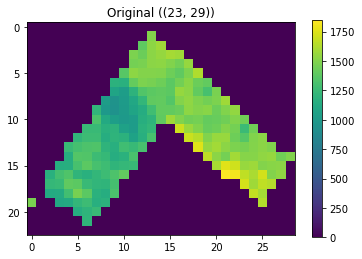

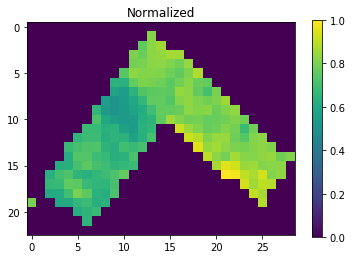

In [11]:
def normalize_img(img, max_val=1, min_val=0):
    img_max = np.max(img)
    img_min = np.min(img)
    img_std = (img - img_min) / (img_max - img_min)
    return img_std * (max_val - min_val) + min_val

plt.figure()
img = train_imgs[train_ids_list.index(FARM_IDX)]
plt.title('Original ({})'.format(img.shape))
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()

plt.figure()
plt.title('Normalized')
plt.imshow(normalize_img(img))
plt.colorbar()
plt.grid(False)
plt.show()

Looks good!




In [12]:
import cv2

def zero_pad_mask(img, shape):
    """
    TODO: Parameterize anchoring
    
    :param img:
    :param shape:
    :return:
    """
    
    # If the image has width > max width, crop to max width
    if img.shape[0] > shape[0]:
        img = img[:shape[0],:]
    
    # If the image has height > max height, crop to max height
    if img.shape[1] > shape[1]:
        img = img[:, :shape[1]]
    
    # Size of border
    v_border = int(np.ceil((shape[0] - img.shape[0]) / 2))
    h_border = int(np.ceil((shape[1] - img.shape[1]) / 2))

    v_diff = shape[0] - (img.shape[0] + 2 * v_border)
    h_diff = shape[1] - (img.shape[1] + 2 * h_border)

    new_img = cv2.copyMakeBorder(
        img,
        top=v_border, bottom=v_border + v_diff,
        left=h_border, right=h_border + h_diff,
        borderType=cv2.BORDER_CONSTANT, 
        value=0
    )

    assert new_img.shape == shape, 'zero padding issue'

    return new_img

### Example of zero-padded farm

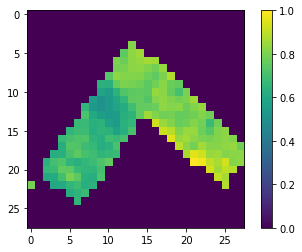

In [13]:
img_norm = normalize_img(img)
zp_img = zero_pad_mask(img_norm, shape=MAX_DIMS)

plt.figure()
plt.imshow(zp_img)
plt.colorbar()
plt.grid(False)
plt.show()

Looks good! - the width was cropped. But this will only happen to 6 images

### Process all images

In [14]:
def process_img(img):
    return zero_pad_mask(normalize_img(img), shape=MAX_DIMS)

def process_data(images, ids, labels=None):
    
    data = np.array(list(map(process_img, images))).reshape(-1, *MAX_DIMS, 1)

    # Remove nans
    nan_idxs = [i for i, img in enumerate(data) if np.isnan(img).any()]
    
    print('Removing {} farms'.format(len(nan_idxs)))

    data = np.delete(data, nan_idxs, axis=0)
    nan_ids = np.array(ids)[nan_idxs]
    
    ids = list(np.delete(ids, nan_idxs))

    if labels is not None:
        labels = np.delete(labels, nan_idxs)
    
    return data, labels, ids, nan_ids

In [15]:
print('Processing training...')
train_data, train_labels, train_ids_list, train_nan_ids = process_data(train_imgs, train_ids_list, train_labels)

print('Processing testing...')
test_data, _, test_ids_list, test_nan_ids = process_data(test_imgs, test_ids_list)

Processing training...
Removing 3 farms
Processing testing...
Removing 71 farms


/Users/renier.botha/anaconda3/envs/zindi_farmpin/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [16]:
def check_for_nans(data):
    for i,arr in enumerate(data):
        if np.isnan(arr).any():
            raise ValueError(f'NaN found at index {i}')
            
check_for_nans(train_data)
check_for_nans(test_data)

In [17]:
print('Train data:\t\t', train_data.shape)
print('Test data:\t\t',test_data.shape)

Train data:		 (2491, 28, 28, 1)
Test data:		 (1003, 28, 28, 1)


## Show examples of training data

In [18]:
random_list = np.random.choice(train_ids_list, size=25)

/Users/renier.botha/anaconda3/envs/zindi_farmpin/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


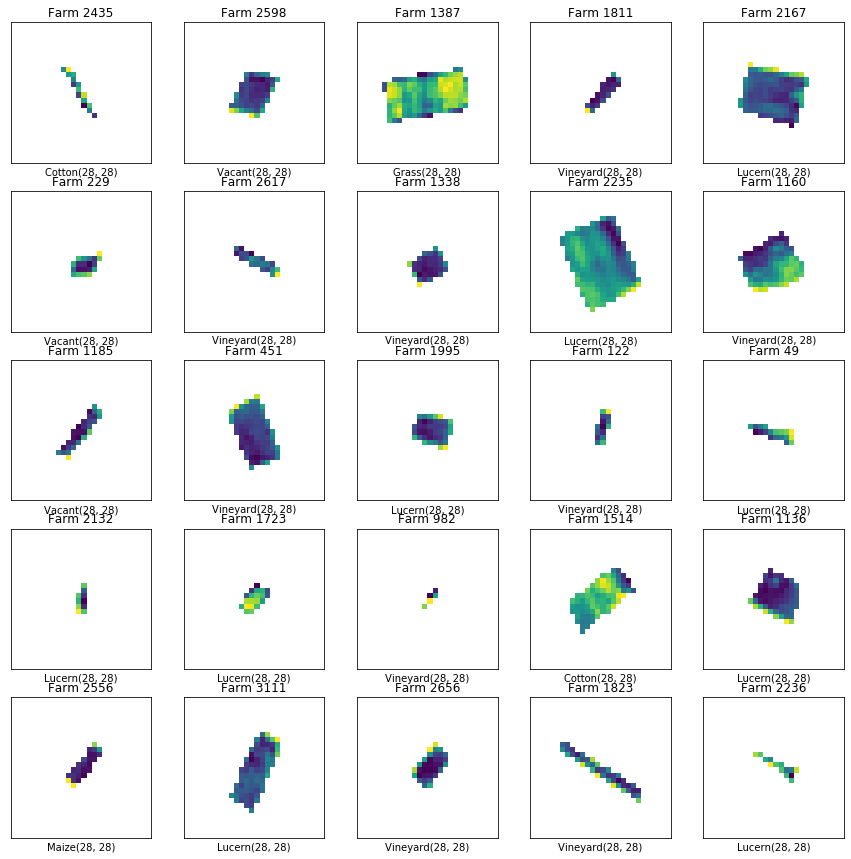

In [19]:
plt.figure(figsize=(15,15))
for i, farm_id in enumerate(random_list):
    
    idx = train_ids_list.index(farm_id)
    label = train_labels[idx]
    class_name = class_names.loc[int(label)].crop
    
    img = train_data[idx][:, :, 0]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Farm ' + str(farm_id))
    plt.grid(False)
    plt.imshow(np.log10(img))
    plt.xlabel(class_name + f'{img.shape}')
    
plt.show()

### Sanity check

Check that after processing the classes and farm IDs match the originals

In [20]:
test = pd.DataFrame({'id': train_ids_list, 'class': train_labels})

for test_id, test_class in zip(train_ids_list, train_labels):
    true_class = train_shp_df.loc[test_id].Crop_Id_Ne
    assert test_class == true_class, f'Farm {test_id} has the incorrect class'

print('success')

success


## Build Model 

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Split training data into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.3, stratify=train_labels, random_state=420)

enc = OneHotEncoder(sparse=False, categories='auto')

train_labels_enc = enc.fit_transform(train_labels.reshape(-1,1))
val_labels_enc = enc.transform(val_labels.reshape(-1,1))

In [22]:
from tensorflow.keras import models, layers

def get_model():
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*MAX_DIMS, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)))
    model.add(layers.Dense(9, activation='softmax'))
    
    return model

In [23]:
model = get_model()

model.compile(optimizer='adam',
              loss=keras.metrics.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_crossentropy])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                495680    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 585       
Total params: 515,081
Trainable params: 515,081
Non-trainable params: 0
__________________________________________________

In [24]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

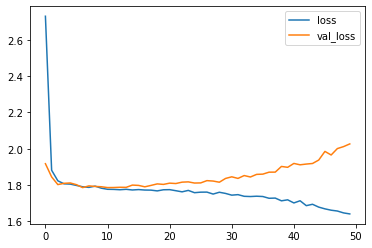

1743/1743 - 1s - loss: 1.6406 - sparse_categorical_crossentropy: 1.5318 - val_loss: 2.0264 - val_sparse_categorical_crossentropy: 1.9162


In [25]:
model.fit(train_data, 
          train_labels,
          batch_size=64,
          validation_data=(val_data, val_labels), 
          verbose=2,
          epochs=50,
         callbacks=[plot_losses])

## Current results

Classifier is overfitting :(

### Make submission

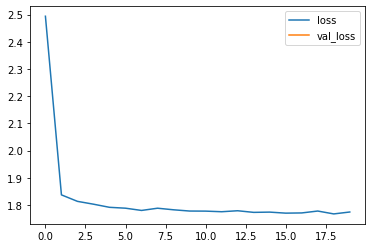

2491/2491 - 1s - loss: 1.7739 - sparse_categorical_crossentropy: 1.7609


In [26]:
data = np.concatenate((train_data, val_data), axis=0)
labels = np.concatenate((train_labels, val_labels), axis=0)

model = get_model()
model.compile(optimizer='adam',
              loss=keras.metrics.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_crossentropy])

model.fit(data, 
          labels,
          batch_size=64,
          verbose=2,
          epochs=20, 
          callbacks=[plot_losses])

In [27]:
predictions = model.predict(test_data)
predictions[:5]

array([[0.07240668, 0.00853351, 0.04907029, 0.17827599, 0.13715464,
        0.06247969, 0.10365193, 0.34619874, 0.04222864],
       [0.05849869, 0.00370306, 0.03421185, 0.19678529, 0.12726036,
        0.04928236, 0.0994667 , 0.3956541 , 0.03513765],
       [0.05869129, 0.0037859 , 0.03437759, 0.20449086, 0.12701175,
        0.05184989, 0.09999239, 0.38476226, 0.03503807],
       [0.05356209, 0.00309628, 0.03019986, 0.20456553, 0.12960002,
        0.04799547, 0.08903527, 0.41062018, 0.03132537],
       [0.07450609, 0.00911303, 0.04879411, 0.17344666, 0.13388182,
        0.0665682 , 0.10756552, 0.3365373 , 0.0495873 ]], dtype=float32)

In [28]:
test_data.shape

(1003, 28, 28, 1)

In [29]:
test_shp_df.head()

,Area,Subregion,geometry
Field_Id,,,
5,1.322590,3,"POLYGON ((614428.5851635702 6794207.23529591, ..."
6,0.955864,3,"POLYGON ((614617.1386412303 6794163.687688111,..."
10,11.509800,3,"POLYGON ((614352.4574846183 6794416.783909474,..."
18,2.697520,3,"POLYGON ((587079.1386775962 6809196.166975806,..."
23,4.238030,3,"POLYGON ((587292.0585372676 6809495.257391035,..."


In [30]:
test_shp_df.loc[test_nan_ids]

,Area,Subregion,geometry
Field_Id,,,
54,2.632320,3,"POLYGON ((587034.0033735929 6809904.693849528,..."
69,4.528320,3,"POLYGON ((585672.3083976685 6809750.549215385,..."
70,0.715439,3,"POLYGON ((585609.2631669876 6809889.694284163,..."
125,1.621480,3,"POLYGON ((611180.4931568142 6800213.09792572, ..."
197,9.508900,1,"POLYGON ((607084.1814842457 6805045.537744238,..."
215,1.879160,1,"POLYGON ((606616.8869872207 6806488.124551135,..."
222,1.345500,1,"POLYGON ((606615.5906259931 6806776.135258779,..."
343,0.798200,3,"POLYGON ((604768.2610021284 6808459.68825761, ..."
518,4.829440,3,"POLYGON ((583159.8376427279 6821093.944477046,..."


In [45]:
def make_sub(predictions, nan_ids):
    
    sub_df = pd.read_csv(os.path.join(raw_data_dir, 'sample_submission_fixed.csv'))

    new_sub = sub_df.copy().set_index('field_id')

    new_sub.loc[test_ids_list] = predictions

    # Fill the missing farms with just zeros for now
    new_sub.loc[test_nan_ids] = np.zeros((len(test_nan_ids), 9))
    
    return new_sub


sub_df = make_sub(predictions, test_nan_ids)

sub_df.head(10)

,crop_id_1,crop_id_2,crop_id_3,crop_id_4,crop_id_5,crop_id_6,crop_id_7,crop_id_8,crop_id_9
field_id,,,,,,,,,
5,0.072407,0.008534,0.049070,0.178276,0.137155,0.062480,0.103652,0.346199,0.042229
6,0.058499,0.003703,0.034212,0.196785,0.127260,0.049282,0.099467,0.395654,0.035138
10,0.058691,0.003786,0.034378,0.204491,0.127012,0.051850,0.099992,0.384762,0.035038
18,0.053562,0.003096,0.030200,0.204566,0.129600,0.047995,0.089035,0.410620,0.031325
23,0.074506,0.009113,0.048794,0.173447,0.133882,0.066568,0.107566,0.336537,0.049587
28,0.062702,0.004953,0.036950,0.190119,0.126312,0.054880,0.091037,0.397042,0.036004
32,0.057037,0.003765,0.034171,0.195397,0.125204,0.049884,0.083615,0.423627,0.027299
35,0.041379,0.001136,0.018337,0.206024,0.093087,0.043983,0.065392,0.509672,0.020990
43,0.067384,0.006396,0.043110,0.182204,0.135581,0.060159,0.101625,0.362516,0.041026


In [46]:
from config import subs_dir

sub_df.to_csv(os.path.join(subs_dir,'keras_basic_band_{}_{}.csv'.format(band, date)))

**Submission score:** 1.812

At least this is sort of close to the train score...